In [1]:
import pandas as pd
import numpy as np
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import os
os.environ['R_HOME'] = '/root/miniconda3/envs/R/lib/R'

import rpy2.robjects as objects
from rpy2.robjects.packages import importr
base = importr('base')
r_pROC = importr("pROC")
base._libPaths()[0]

def df_stats(df):
    from tabulate import tabulate
    print("\n***** Shape: ", df.shape," *****\n")
    
    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()
    
    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=['Name', 'Null', 'Unique', 'Dtypes'])
    print(tabulate(df_stat_val, headers='keys', tablefmt='psql'))
    return df.head()

/tmp/ipykernel_251447/4163889655.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Process current extraction

In [2]:
data = pd.read_csv('data/database-c-find_missing_audit_20231016.csv')

In [3]:
try:
    # Drop the unnecessary index column
    data = data.drop(columns=['Unnamed: 0'])
except:
    pass

# Groupby 'StudyInstanceUID' and keep the first 'PatientID' for each unique 'StudyInstanceUID'
data = data.groupby('StudyInstanceUID').first().reset_index()

# Add 'Status' and 'QueryRetrieveLevel' columns
data['Status'] = '0x0'
data['QueryRetrieveLevel'] = 'STUDY'

# Reorder columns to match the desired format
data = data[['PatientID', 'QueryRetrieveLevel', 'Status', 'StudyInstanceUID']]

data.head()


,PatientID,QueryRetrieveLevel,Status,StudyInstanceUID
0,605689,STUDY,0x0,2.16.124.113611.1.118.1.1.6150196
1,188123,STUDY,0x0,2.16.124.113611.1.118.1.1.6165090
2,609084,STUDY,0x0,2.16.124.113611.1.118.1.1.6169622
3,609217,STUDY,0x0,2.16.124.113611.1.118.1.1.6171911
4,611530,STUDY,0x0,2.16.124.113611.1.118.1.1.6216950


In [4]:
#data.to_csv('data/database-c-find_missing_audit_20231016_for_cmove.csv')

In [4]:
df_new = pd.DataFrame()
df_new['PateintID'] = df['Patient ID']
#df_new['QueryRetrieveLevel'] = 'SERIES'
df_new['StudyInstanceUID'] = df['Study UID']
df_new['SeriesInstanceUID'] = df['Series UID']
display(df_new)
df_new.to_csv('data/audit-inference-20210803-20230803.csv')

NameError: name 'df' is not defined

9411

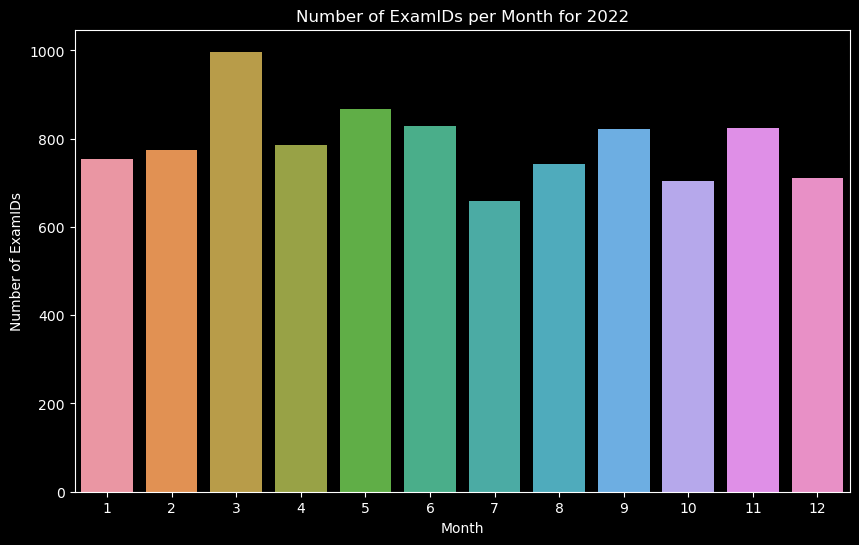

In [7]:
#2022 angiogram c-find
df_xa = pd.read_csv('data/database-c-find_TTE2022_20220101-20221231.XA2.csv')
df_xa['StudyDate'] = pd.to_datetime(df_xa['StudyDate'], format='%Y%m%d')
display(df_xa.StudyInstanceUID.nunique())
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_xa is your DataFrame with 'StudyDate'
# Adding a column to represent the month
df_xa['Month'] = df_xa['StudyDate'].dt.month

# Grouping by month and counting the number of ExamIDs
monthly_counts = df_xa.groupby('Month').size().reset_index(name='Number of ExamIDs')

# Plotting the data using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Number of ExamIDs', data=monthly_counts)
plt.title('Number of ExamIDs per Month for 2022')
plt.xlabel('Month')
plt.ylabel('Number of ExamIDs')
plt.show()


## Check extraction of CAthEF DICOMs


In [59]:
df_to_extract = pd.read_csv('data/audit-inference-20210803-20230803_extract.csv')
df_to_extract = df_to_extract.groupby(['StudyInstanceUID']).first().reset_index()

In [60]:
display(df_stats(df_to_extract))


***** Shape:  (232, 4)  *****

+----+--------------------+--------+----------+----------+
|    | Name               |   Null |   Unique | Dtypes   |
|----+--------------------+--------+----------+----------|
|  0 | StudyInstanceUID   |      0 |      232 | object   |
|  1 | PatientID          |      0 |      226 | object   |
|  2 | QueryRetrieveLevel |      0 |        1 | object   |
|  3 | Status             |      0 |        3 | object   |
+----+--------------------+--------+----------+----------+


,StudyInstanceUID,PatientID,QueryRetrieveLevel,Status
0,1.3.12.2.1107.5.4.5.135214.30000023020211373582800000022,183774,STUDY,0x0
1,1.3.12.2.1107.5.4.5.140409.30000023052511290500900000001,624901,STUDY,0x0
2,1.3.12.2.1107.5.4.5.147598.30000023070510560571700000017,490419,STUDY,0x0
3,1.3.46.670589.29.18771927773542520221026164809519,615116,STUDY,0x0
4,1.3.6.1.4.1.23849.3236648407.188.1638239820133743431,563528,STUDY,0xb000


In [61]:
#df_to_extract = pd.read_csv('data/database-c-find_missing_audit_20231016_for_cmove_extracted.csv')
display(df_to_extract.loc[df_to_extract['StudyInstanceUID']=='2.16.124.113611.1.118.1.1.6539447'])

,StudyInstanceUID,PatientID,QueryRetrieveLevel,Status
201,2.16.124.113611.1.118.1.1.6539447,558612,STUDY,0x0


In [43]:
from tqdm import tqdm
import os
import pydicom
import pandas as pd

def scan_dicoms_and_append_to_dataframe(root_folder, output_folder='.'):
    # Creating a list to hold DICOM information
    dicom_list = []

    # Gathering all the DICOM files first to have an accurate progress bar
    dicom_files = [os.path.join(subdir, file) for subdir, _, files in os.walk(root_folder) for file in files if file.endswith('.dcm')]
    print(len(dicom_files))
    # Iterating through the DICOM files with a progress bar
    for file_path in tqdm(dicom_files, desc='Scanning DICOMs'):
        # Reading the DICOM file
        dicom_data = pydicom.dcmread(file_path)

        # Extracting PatientID and StudyInstanceUID
        patient_id = dicom_data.PatientID
        study_instance_uid = dicom_data.StudyInstanceUID

        # Appending the information to the list
        dicom_list.append({
            'PatientID': patient_id,
            'StudyInstanceUID': study_instance_uid,
            'FilePath': file_path
        })

    # Creating a DataFrame from the list
    dicom_df = pd.DataFrame(dicom_list, columns=['PatientID', 'StudyInstanceUID', 'FilePath'])

    # Create a folder to store the data if it doesn't exist
    if not os.path.exists(os.path.join(output_folder, 'CathEF_Prospective')):
        os.makedirs(os.path.join(output_folder, 'CathEF_Prospective'))

    # Saving the DataFrame to a CSV file in the CathEF_Prospective folder
    output_path = os.path.join(output_folder, 'CathEF_Prospective', 'dicom_data.csv')
    dicom_df.to_csv(output_path, index=False)

    return dicom_df


In [44]:

# Using the function
root_folder = '/media/data1/ravram/CathEF_Prospective'
dicom_df = scan_dicoms_and_append_to_dataframe(root_folder)

dicom_df.to_csv('../Oread/data/CathEF_Prospective/CathEF_inference-20231016_FINAL.csv')

5517


Scanning DICOMs: 100%|██████████| 5517/5517 [02:22<00:00, 38.68it/s] 


In [62]:
output_folder = "."
print(os.path.exists(os.path.join(output_folder, 'CathEF_Prospective')))

True


In [76]:
display(df_to_extract.loc[df_to_extract['PatientID']=='537519'])

,StudyInstanceUID,PatientID,QueryRetrieveLevel,Status
124,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0


In [94]:
dicom_df = pd.read_csv('../Oread/data/CathEF_Prospective/CathEF_inference-20231016_FINAL.csv')
#display(dicom_df.StudyInstanceUID.nunique())

#dicom_df_grouped = pd.merge(df_to_extract, dicom_df, on='StudyInstanceUID', how='left')
##Rename PatientID_x to PatientID
#dicom_df_grouped = dicom_df_grouped.rename(columns={'PatientID_x':'PatientID'})
#dicom_df_grouped = dicom_df_grouped.rename(columns={'PatientID_y':'PatientID_anon'})
#dicom_df_grouped.to_csv('../Oread/data/CathEF_Prospective/CathEF_inference-20231016_FINAL.csv')

In [67]:
df_cath_ef_audit = pd.read_csv('../Oread/data/CathEF_Prospective/ICM_audit-inference-20210101-20231004.csv')
#Rename df_cath_audit['Study UID'] to ['StudyInstanceUID']
df_cath_ef_audit.rename(columns={'Study UID':'StudyInstanceUID'}, inplace=True)


,Author,Timestamp,Algorithm,Patient ID,StudyInstanceUID,Accession Number,Series,Series UID,Instance UID,Detected Vessel,LVEF
1056,yan.xu.rong@umontreal.ca,1689087588518,Cath-EF,558612,2.16.124.113611.1.118.1.1.6539447,HE202300536001,Series 1,1.3.46.670589.29.1877192777354251333330224226435582,1.3.46.670589.29.1877192777354251333330224227336030708110409030,Left Coronary,34.163666
1057,yan.xu.rong@umontreal.ca,1689087588518,Cath-EF,558612,2.16.124.113611.1.118.1.1.6539447,HE202300536001,Series 2,1.3.46.670589.29.1877192777354251333330225957744962,1.3.46.670589.29.1877192777354251333330225958645400708110426030,Left Coronary,46.563698
1058,yan.xu.rong@umontreal.ca,1689087588518,Cath-EF,558612,2.16.124.113611.1.118.1.1.6539447,HE202300536001,Series 3,1.3.46.670589.29.1877192777354251333330227771192652,1.3.46.670589.29.1877192777354251333330227772093150708110444030,Right Coronary,0.000000


In [69]:
# show df_cath_ef_audit['Study UID'] that is in dicom_df['StudyInstanceUID']
display("Missing patients from dicoms extracted by PyDicom - 316586 is NOT included in CathEF", df_cath_ef_audit.loc[~df_cath_ef_audit['StudyInstanceUID'].isin(dicom_df_grouped['StudyInstanceUID'])]['Patient ID'].value_counts())
## merge df_cath_ef_audit['Study UID'] and dicom_df['StudyInstanceUID'] inner
#df_cath_ef_audit = pd.merge(df_cath_ef_audit, dicom_df, left_on='Study UID', right_on='StudyInstanceUID', how='inner')


'Missing patients from dicoms extracted by PyDicom - 316586 is NOT included in CathEF'

316586    2
Name: Patient ID, dtype: int64

In [70]:
df_cath_ef_audit_m = df_cath_ef_audit.groupby(['StudyInstanceUID']).first().reset_index()
display(df_cath_ef_audit_m.describe())

,LVEF
count,225.000000
mean,42.752706
std,22.567325
min,0.000000
25%,38.164974
50%,53.518024
75%,58.666428
max,67.238998


In [80]:
display(dicom_df_grouped.loc[dicom_df_grouped['PatientID_x']=='537519'])
display(df_redcap.loc[df_redcap['selection_recordnumb']==' 537519'])


,StudyInstanceUID,PatientID_x,QueryRetrieveLevel,Status,Unnamed: 0,PatientID_y,FilePath
3211,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1336.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030312314743700000001.dcm
3212,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1337.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000087.dcm
3213,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1338.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000090.dcm
3214,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1339.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000100.dcm
3215,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1340.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000103.dcm
3216,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1341.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000106.dcm
3217,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1342.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000109.dcm
3218,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1343.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.2.276.0.7230010.3.1.3.477015473.11336.1677856225.794.dcm
3219,2.16.124.113611.1.118.1.1.6410234,537519,STUDY,0x0,1344.0,329932405897386481019777609764905762062,/media/data1/ravram/CathEF_Prospective/329932405897386481019777609764905762062/2.16.124.113611.1.118.1.1.6410234/1.3.12.2.1107.5.4.5.135214.30000023030311325570300000079.dcm


,record_id,redcap_data_access_group,selection_recordnumb,inclusion_age,inclusion_signed_consent,inclusion_acs,inclusion_creatinine,exclusion_tte,exclusion_rbbb,exclusion_clot,exclusion_dissection,exclusion_ventriculography,exclusion_injection,selection_consent___1,selection_copy___1,selection_indication,date_consent,seleciton_eligibility,screening_visit_complete,selection_demog_gender,selection_demog_origin___1,selection_demog_origin___2,selection_demog_origin___3,selection_demog_origin___4,selection_demog_origin___5,selection_demog_dob,selection_hist_lvef,selection_hist_lvefd,selection_hist_lvefm,selection_hist_infarction,selection_hist_cabg,selection_hist_pci,selection_hist_heartfail,selection_hist_pacemaker,selection_hist_renalfail,selection_hist_thyro,selection_hist_valv___1,selection_hist_valv___2,selection_hist_valv___3,selection_hist_valv___4,selection_hist_valv___5,selection_hist_diabetes,selection_hist_dyslipid,selection_hist_tabac,selection_hist_hypertens,selection_hist_cad,selection_notes,base_blood_sampled,base_blood_sampledate,base_blood_hgb,base_blood_creat,base_blood_creatclear,base_blood_troponins,troponin_type,base_blood_nt,base_angiog_date,base_angiog_vascacc___1,base_angiog_vascacc___2,base_angiog_vascacc___3,base_angiog_vascacc___4,base_angiog_contrast,base_sten_lmain,base_sten_proxante,base_sten_midante,base_sten_distante,base_sten_diag1,base_sten_diag2,base_sten_ramus,base_sten_proxcirc,base_sten_distcirc,base_sten_marg1,base_sten_marg2,base_sten_proxrcor,base_sten_midrcor,base_sten_distrcor,base_sten_descpost,base_sten_postlat,base_sten_postlat_2,base_sten_left_postlat_1,base_sten_left_postlat_2,base_angiop_date,base_angiop_treat___1,base_angiop_treat___2,base_angiop_treat___3,base_angiop_treat___4,base_angiop_treat___5,base_angiop_treat___6,base_angiop_treat___7,base_angiop_treat___8,base_angiop_treat___9,base_angiop_treat___10,base_angiop_treat___11,base_angiop_treat___12,base_angiop_treat___13,base_angiop_treat___14,base_angiop_treat___15,base_angiop_treat___16,base_angiop_treat___17,base_angiop_treat___18,base_angiop_culprit___1,base_angiop_culprit___2,base_angiop_culprit___3,base_angiop_culprit___4,base_angiop_culprit___5,base_angiop_culprit___6,base_angiop_culprit___7,base_angiop_culprit___8,base_angiop_culprit___9,base_angiop_culprit___10,base_angiop_culprit___11,base_angiop_culprit___12,base_angiop_culprit___13,base_angiop_culprit___14,base_angiop_culprit___15,base_angiop_culprit___16,base_angiop_culprit___17,base_angiop_culprit___18,base_ventri_done,base_ventri_date,base_ventri_outp,base_ventri_lvef,base_ventri_normk___1,base_ventri_normk___2,base_ventri_normk___3,base_ventri_normk___4,base_ventri_normk___5,base_ventri_normk___6,base_ventri_akin___1,base_ventri_akin___2,base_ventri_akin___3,base_ventri_akin___4,base_ventri_akin___5,base_ventri_akin___6,base_ventri_hypok___1,base_ventri_hypok___2,base_ventri_hypok___3,base_ventri_hypok___4,base_ventri_hypok___5,base_ventri_hypok___6,base_ventri_dysk___1,base_ventri_dysk___2,base_ventri_dysk___3,base_ventri_dysk___4,base_ventri_dysk___5,base_ventri_dysk___6,base_ventri_mi,base_cef_taken,base_cef_date,base_values_visit_complete,v1_blood_sampled,v1_blood_hgb,v1_blood_sampledate,v1_blood_creat,v1_blood_creatclear,v1_blood_troponins,troponin_type_visit_1,v1_blood_nt,visit_1_complete,vf_blood_sampled,vf_blood_sampledate,vf_blood_hgb,vf_blood_creat,vf_blood_creatclear,vf_blood_troponins,troponin_type_final_visit,vf_blood_nt,final_visit_complete,tte_taken,tte_date,tte_seg1,tte_seg2,tte_seg3,tte_seg4,tte_seg5,tte_seg6,tte_seg7,tte_seg8,tte_seg9,tte_seg10,tte_seg11,tte_seg12,tte_seg13,tte_seg14,tte_seg15,tte_seg16,tte_seg17,tte_lvef,tte_aneur,tte_method___1,tte_method___2,tte_method___3,tte_method___4,tte_method___5,tte_pilrupt,tte_coms,tte_aosten___1,tte_aosten___2,tte_aosten___3,tte_aosten___4,tte_aoinsuf,tte_mitsten___1,tte_mitsten___2,tte_mitsten___3,tte_mitsten___4,tte_mitinsuf,tte_triinsuf,transthoracic_echocardiography_complete,adverse_deathanyc,adv

In [83]:
df_redcap = pd.read_csv('../Oread/data/CathEF_Prospective/CathEF_DATA_2023-10-14_1251_ALL.csv')
#In df_redcap replace ' 537519' with '537519'
df_redcap['selection_recordnumb'] = df_redcap['selection_recordnumb'].str.replace(' ', '')
#df_redcap.to_csv('../Oread/data/CathEF_Prospective/CathEF_DATA_2023-10-14_1251_ALL.csv')

# show df_cath_ef_audit['Study UID'] that is in dicom_df['StudyInstanceUID']
display(df_redcap.loc[~df_redcap['selection_recordnumb'].isin(dicom_df_grouped['PatientID_x'])]['selection_recordnumb'].value_counts())
## merge df_cath_ef_audit['Study UID'] and dicom_df['StudyInstanceUID'] inner
#df_cath_ef_audit = pd.merge(df_cath_ef_audit, dicom_df, left_on='Study UID', right_on='StudyInstanceUID', how='inner')


## All patients are found except UOHI which have been extracted already. 

48-1     1
48-54    1
48-62    1
48-61    1
48-60    1
48-59    1
48-58    1
48-57    1
48-56    1
48-55    1
48-53    1
48-2     1
48-52    1
48-51    1
48-50    1
48-49    1
48-48    1
48-47    1
48-46    1
48-45    1
48-63    1
48-64    1
48-65    1
48-66    1
48-83    1
48-82    1
48-81    1
48-80    1
48-79    1
48-78    1
48-77    1
48-76    1
48-75    1
48-74    1
48-73    1
48-72    1
48-71    1
48-70    1
48-69    1
48-68    1
48-67    1
48-44    1
48-43    1
48-42    1
48-21    1
48-19    1
48-18    1
48-17    1
48-16    1
48-15    1
48-14    1
48-13    1
48-12    1
48-11    1
48-10    1
48-9     1
48-8     1
48-7     1
48-6     1
48-5     1
48-4     1
48-3     1
48-20    1
48-22    1
48-41    1
48-23    1
48-40    1
48-39    1
48-38    1
48-37    1
48-36    1
48-35    1
48-34    1
48-33    1
48-32    1
48-31    1
48-30    1
48-29    1
48-28    1
48-27    1
48-26    1
48-25    1
48-24    1
48-84    1
Name: selection_recordnumb, dtype: int64